# Продвинутый SQL

Выполните продвинутые задания по SQL. Задания включают дополнительные вопросы, дайте на них ответ.

Необходимые данные находятся в таблицах схемы `stackoverflow`. Не забудьте подключиться к базе с помощью SQLAlchemy.

Чтобы ожидаемый результат было легче представить, к каждому заданию добавлен небольшой фрагмент итоговой таблицы.

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
from dotenv import load_dotenv

In [2]:
load_dotenv()

USER = os.getenv('USER')
PWD = os.getenv('PWD')
HOST = os.getenv('HOST')
PORT = os.getenv('PORT')
DB = os.getenv('DB')

Конфигурация для подключения к базе данных `data-analyst-advanced-sql`

Эта база данных содержит схему `stackoverflow`, с которой вы будете работать в проекте

In [3]:
connection_string = f'postgresql://{USER}:{PWD}@{HOST}:{PORT}/{DB}'

Создание подключения

In [4]:
engine = create_engine(connection_string) 

Пример запроса к базе данных

`sample_df` является pandas-датафреймом.

In [5]:
query = '''
SELECT *
FROM stackoverflow.users
LIMIT 10;
'''

sample_df = pd.read_sql_query(query, con=engine) 

In [5]:
sample_df

,id,creation_date,display_name,last_access_date,location,reputation,views
0,1,2008-07-31 14:22:31,Jeff Atwood,2018-08-29 02:34:23,"El Cerrito, CA",44300,408587
1,2,2008-07-31 14:22:31,Geoff Dalgas,2018-08-23 17:31:56,"Corvallis, OR",3491,23966
2,3,2008-07-31 14:22:31,Jarrod Dixon,2018-08-30 20:56:24,"Raleigh, NC, United States",13418,24396
3,4,2008-07-31 14:22:31,Joel Spolsky,2018-08-14 22:18:15,"New York, NY",28768,73755
4,5,2008-07-31 14:22:31,Jon Galloway,2018-08-29 16:48:36,"San Diego, CA",39172,11700
5,8,2008-07-31 21:33:24,Eggs McLaren,2018-04-09 02:04:56,None,942,6372
6,9,2008-07-31 21:35:27,Kevin Dente,2018-08-30 18:18:03,"Oakland, CA",14337,4949
7,11,2008-08-01 00:59:11,Anonymous User,2008-08-01 00:59:11,None,1890,2123
8,13,2008-08-01 04:18:05,Chris Jester-Young,2018-08-30 02:47:23,"Raleigh, NC, United States",177138,35414
9,17,2008-08-01 12:02:22,Nick Berardi,2018-01-22 01:35:38,"Issaquah, WA",44443,4786


## Задание 1

Выведите общую сумму просмотров постов за каждый месяц 2008 года. Если данных за какой-либо месяц в базе нет, такой месяц можно пропустить. Результат отсортируйте по убыванию общего количества просмотров.

| month_date  | total_views |
| ------------- | ------------- |
| 2008-09-01  | 452928568  |
| 2008-10-01  | 365400138  |
| ...         | ... |

In [6]:
query = '''
SELECT
    DISTINCT DATE_TRUNC('MONTH', creation_date) AS month_date,
    SUM(views_count) OVER(PARTITION BY DATE_TRUNC('MONTH', creation_date)) AS total_views
FROM stackoverflow.posts
WHERE EXTRACT(YEAR FROM creation_date) = 2008
ORDER BY total_views DESC
'''

sample_df = pd.read_sql_query(query, con=engine) 
sample_df

,month_date,total_views
0,2008-09-01,452928568
1,2008-10-01,365400138
2,2008-11-01,221759651
3,2008-12-01,197792841
4,2008-08-01,131367083
5,2008-07-01,669895


Проанализируйте итоговую таблицу. Отличаются ли данные за разные месяцы? С чем могут быть связаны отличия?

**Ответ:**

- В Июле гораздо меньшее значение среди всех остальных, вдимо это начало работы сервиса до стадии закрытого бета-тестирования
- Значительный рост в Августе по сравнению с Июлем, запуск закрытого бета-теста 31 июля, порядок количества постов увеличился с сотен тысячь до сотен милиионов
- В Сентябре произошёл скачок по сравнению с Августом примерно в 4 раза, максимальное значение среди всех, 15 сентября была запущена публичная-бета
- С Сентября по Декабрь происходит плавный спад, в итоге постов стали публиковать в 2 раза меньше. Причинами могут быть
    - большое количество уже существущих постов где уже есть ответы на вопросы
    - естественный отток клиентов после запуска
    - сезонные отпуска и праздники

## Задание 2

Выведите имена самых активных пользователей, которые в первый месяц после регистрации (включая день регистрации) дали больше 100 ответов. Вопросы, которые задавали пользователи, не учитывайте. Для каждого имени пользователя выведите количество уникальных значений `user_id`. Отсортируйте результат по полю с именами в лексикографическом порядке.

| display_name | count |
| ------------ | ----- |
| 1800 INFORMATION | 1 |
| Adam Bellaire | 1 |
| Adam Davis | 1 |
| ... | ... |

In [7]:
query = '''
SELECT
    su.display_name,
    COUNT(DISTINCT su.id)
FROM stackoverflow.posts AS sp
JOIN stackoverflow.post_types AS spt ON sp.post_type_id = spt.id
JOIN stackoverflow.users AS su ON sp.user_id = su.id
WHERE
    spt.type = 'Answer' AND
    sp.creation_date - su.creation_date <= '30 DAYS'
GROUP BY su.display_name
HAVING COUNT(sp.id) > 100
ORDER BY su.display_name
'''

sample_df = pd.read_sql_query(query, con=engine)
sample_df

,display_name,count
0,1800 INFORMATION,1
1,Adam Bellaire,1
2,Adam Davis,1
3,Adam Liss,1
4,Alan,8
...,...,...
71,leppie,1
72,lomaxx,1
73,mattlant,1
74,paxdiablo,1


Какие аномалии наблюдаются в данных? О чём они говорят?

In [8]:
sample_df['count'].unique()

array([ 1,  8, 15, 29, 10, 21, 12,  7,  9, 16,  5, 11,  3, 19],
      dtype=int64)

**Ответ:**

- Некоторые имена пользователей встречаются не один раз, значит они не уникальны

## Задание 3

Выведите количество постов за 2008 год по месяцам. Отберите посты от пользователей, которые зарегистрировались в сентябре 2008 года и сделали хотя бы один пост в декабре того же года. Отсортируйте таблицу по значению месяца по убыванию.

| month | count |
| ------|------ |
| 2008-12-01 | 17641 |
| 2008-11-01 | 18294 |
| ... | ... |

In [9]:
query = '''
SELECT
    DISTINCT DATE_TRUNC('MONTH', creation_date),
    COUNT(*) OVER(PARTITION BY DATE_TRUNC('MONTH', creation_date))
FROM stackoverflow.posts
WHERE user_id IN (
    SELECT DISTINCT su.id
    FROM stackoverflow.users AS su
    JOIN stackoverflow.posts AS sp ON sp.user_id = su.id
    WHERE
        DATE_TRUNC('MONTH', su.creation_date) = '2008-09-01' AND
        DATE_TRUNC('MONTH', sp.creation_date) = '2008-12-01'
)
ORDER BY date_trunc DESC
'''

sample_df = pd.read_sql_query(query, con=engine)
sample_df

,date_trunc,count
0,2008-12-01,17641
1,2008-11-01,18294
2,2008-10-01,27171
3,2008-09-01,24870
4,2008-08-01,32


Изучите данные: есть ли в них аномалии? Предположите, почему могли появиться аномальные значения.

**Ответ:**

- Аномалия в в том что данные пользователей которые зарегестрировались в Сентябре, а посты сделаны в Августе, то есть ещё до регистрации чего быть не может. Это может быть вызвано программной ошибкой или техническим сбоем в тестовый период.

## Задание 4

Используя данные о постах, выведите несколько полей:

- идентификатор пользователя, который написал пост;
- дата создания поста;
- количество просмотров у текущего поста;
- сумму просмотров постов автора с накоплением.

Данные в таблице должны быть отсортированы по возрастанию идентификаторов пользователей, а данные об одном и том же пользователе — по возрастанию даты создания поста.

| user_id | creation_date | views_count | cumulative_count |
| ------ | -------------- | ----------- | ---------------- |
| 1 | 2008-07-31 23:41:00  | 480476   | 480476  |
| 1 | 2008-07-31 23:55:38  | 136033 | 616509  | 
| 1 | 2008-07-31 23:56:41  | 0 |  616509  |
| ... | ... | ... | ... |
| 2 | 2008-07-31 23:56:41 | 79087  | 79087 |
| 2 | 2008-08-01 05:09:56 | 65443 | 144530 |
| ... | ...  | ...  | ...  |

In [10]:
query = '''
SELECT
    user_id,
    creation_date,
    views_count,
    SUM(views_count) OVER(PARTITION BY user_id ORDER BY creation_date) AS cumulative_count
FROM stackoverflow.posts
ORDER BY user_id, creation_date
'''

sample_df = pd.read_sql_query(query, con=engine)
sample_df

,user_id,creation_date,views_count,cumulative_count
0,1,2008-07-31 23:41:00,480476,480476
1,1,2008-07-31 23:55:38,136033,616509
2,1,2008-07-31 23:56:41,0,616509
3,1,2008-08-04 02:45:08,0,616509
4,1,2008-08-04 04:31:03,0,616509
...,...,...,...,...
243791,5696608,2008-12-23 16:00:37,0,2804
243792,5696608,2008-12-23 17:35:09,0,2804
243793,5696608,2008-12-24 01:02:48,0,2804
243794,5696608,2008-12-30 14:34:45,0,2804


## Задание 5

Найдите среднее количество постов пользователей в день за август 2008 года. Отберите данные о пользователях, которые опубликовали больше 120 постов за август. Дни без публикаций не учитывайте. 

Отсортируйте результат по возрастанию среднего количества постов. Значения можно не округлять.

| user_id | avg_daily |
| ------- | --------- |
| 116     | 4.777778  |
| 234     | 5.208333  |
| ...     | ... |

In [11]:
# хуже
query = '''
SELECT
    DISTINCT user_id,
    AVG(count) OVER(PARTITION BY user_id) AS avg_daily
FROM (
    SELECT
        DISTINCT user_id,
        DATE_TRUNC('DAY', creation_date),
        COUNT(*)
    FROM stackoverflow.posts
    WHERE
        user_id IN (
            SELECT user_id
            FROM (
                SELECT
                    DISTINCT user_id,
                    COUNT(*) OVER(PARTITION BY user_id)
                FROM stackoverflow.posts
                WHERE DATE_TRUNC('MONTH', creation_date) = '2008-08-01'
            ) AS up
            WHERE count > 120
        ) AND
        DATE_TRUNC('MONTH', creation_date) = '2008-08-01'
    GROUP BY user_id, DATE_TRUNC('DAY', creation_date)
) AS fin
WHERE DATE_TRUNC('MONTH', date_trunc) = '2008-08-01'
ORDER BY avg_daily
'''

# лучше
query = '''
SELECT
    DISTINCT user_id,
    AVG(count) OVER(PARTITION BY user_id) AS avg_daily
FROM (
    SELECT
        user_id,
        DATE_TRUNC('DAY', creation_date),
        COUNT(id)
    FROM stackoverflow.posts
    WHERE
        user_id IN (
            SELECT user_id
            FROM stackoverflow.posts
            WHERE DATE_TRUNC('MONTH', creation_date) = '2008-08-01'
            GROUP BY user_id
            HAVING COUNT(id) > 120
        )
    GROUP BY user_id, DATE_TRUNC('DAY', creation_date)
) AS fin
WHERE DATE_TRUNC('MONTH', date_trunc) = '2008-08-01'
ORDER BY avg_daily
'''

sample_df = pd.read_sql_query(query, con=engine)
sample_df

,user_id,avg_daily
0,116,4.777778
1,234,5.208333
2,91,5.681818
3,905,7.000000
4,383,7.277778


## Задание 6

Сколько в среднем дней в период с 1 по 7 декабря 2008 года пользователи взаимодействовали с платформой? Для каждого пользователя отберите дни, в которые он или она опубликовали хотя бы один пост. Нужно получить одно целое число — не забудьте округлить результат. 

| result |
| -----  |
| <целое число> |

In [12]:
query = '''
SELECT ROUND(AVG(count))::int
FROM (
    SELECT COUNT(DISTINCT creation_date::date)
    FROM stackoverflow.posts
    WHERE creation_date::DATE BETWEEN '2008-12-01' AND '2008-12-07'
    GROUP BY user_id
) AS fin
'''

sample_df = pd.read_sql_query(query, con=engine)
sample_df

,round
0,2


Проанализируйте итоговую таблицу — какие выводы можно сделать?

**Ответ:**

- В период с 1 по 7 декабря 2008 года пользователи взаимодействовали с платформой в среднем 2 раза

## Задание 7

Выведите историю активности каждого пользователя в таком виде: идентификатор пользователя, дата публикации поста. Отсортируйте вывод по возрастанию идентификаторов пользователей, а для каждого пользователя — по возрастанию даты публикации.

Добавьте в таблицу новое поле: для каждого поста в нём будет указано название месяца предпоследней публикации пользователя относительно текущей. Если такой публикации нет, укажите `NULL`.  Python автоматически поменяет `NULL` на `None`, но дополнительно преобразовывать значения `None` вам не нужно.

Посмотрите внимательно на образец таблицы: для первых двух постов предпоследней публикации нет, но, начиная с третьего поста, в новое поле входит нужный месяц. Для следующего пользователя в первые две записи поля `second_last_month` тоже войдёт `NULL`.

| user_id | creation_date | second_last_month |
| ------- | ------------- | ----------------- |
| 1       | 2008-07-31 23:41:00 | None |
| 1       | 2008-07-31 23:55:38 | None |
| 1       | 2008-07-31 23:56:41 | July |
| 1       | 2008-08-04 02:45:08 | July |
| 1       | 2008-08-04 04:31:03 | July |
| 1       | 2008-08-04 08:04:42 | August |
| ... | ... | ... |

In [13]:
query = '''
SELECT
    user_id,
    creation_date,
    TO_CHAR(LAG(creation_date, 2) OVER(PARTITION BY user_id ORDER BY creation_date), 'Month')
FROM stackoverflow.posts
ORDER BY user_id
'''

sample_df = pd.read_sql_query(query, con=engine)
sample_df

,user_id,creation_date,to_char
0,1,2008-07-31 23:41:00,None
1,1,2008-07-31 23:55:38,None
2,1,2008-07-31 23:56:41,July
3,1,2008-08-04 02:45:08,July
4,1,2008-08-04 04:31:03,July
...,...,...,...
243791,5696608,2008-12-23 16:00:37,December
243792,5696608,2008-12-23 17:35:09,December
243793,5696608,2008-12-24 01:02:48,December
243794,5696608,2008-12-30 14:34:45,December


## Задание 8

Рассчитайте аналог Retention Rate по месяцам для пользователей StackOverflow. Объедините пользователей в когорты по месяцу их первого поста. Возвращение определяйте по наличию поста в текущем месяце. 

| cohort_dt | session_date | users_cnt | cohort_users_cnt | retention_rate |
| --- | --- | --- | --- | --- |
| 2008-07-01 00:00:00 | 2008-07-01 00:00:00 | 3 | 3 | 100 |
| 2008-07-01 00:00:00 | 2008-08-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-07-01 00:00:00 | 2008-09-01 00:00:00 | 1 | 3 | 33,33 |
| 2008-07-01 00:00:00 | 2008-10-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-07-01 00:00:00 | 2008-11-01 00:00:00 | 1 | 3 | 33,33 |
| 2008-07-01 00:00:00 | 2008-12-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-08-01 00:00:00 | 2008-08-01 00:00:00 | 2151 | 2151 | 100 |
| ... | ... | ... | ... | ... |

In [14]:
query = '''
WITH
    cohort_users_count AS (
        SELECT
            *,
            COUNT(user_id) OVER(PARTITION BY cohort_dt) AS cohort_users_cnt
        FROM (
            SELECT
                DISTINCT user_id,
                MIN(DATE_TRUNC('month', creation_date)) OVER (PARTITION BY user_id) AS cohort_dt
            FROM stackoverflow.posts
        ) AS uc
    ),
        
    sessions AS (
        SELECT
            user_id,
            DATE_TRUNC('month', creation_date) AS session_date
        FROM stackoverflow.posts
        GROUP BY user_id, session_date
    )

SELECT
    cuc.cohort_dt,
    s.session_date,
    COUNT(cuc.user_id) AS users_cnt,
    cuc.cohort_users_cnt,
    ROUND(COUNT(cuc.user_id) * 100.0 / cohort_users_cnt, 2) AS retention_rate
FROM cohort_users_count AS cuc
JOIN sessions AS s ON s.user_id = cuc.user_id
GROUP BY cuc.cohort_dt, s.session_date, cuc.cohort_users_cnt
'''

sample_df = pd.read_sql_query(query, con=engine)
sample_df

,cohort_dt,session_date,users_cnt,cohort_users_cnt,retention_rate
0,2008-07-01,2008-10-01,2,3,66.67
1,2008-10-01,2008-12-01,1221,3629,33.65
2,2008-12-01,2008-12-01,2536,2536,100.00
3,2008-08-01,2008-08-01,2151,2151,100.00
4,2008-08-01,2008-12-01,894,2151,41.56
5,2008-09-01,2008-11-01,2966,7678,38.63
6,2008-07-01,2008-07-01,3,3,100.00
7,2008-09-01,2008-10-01,4132,7678,53.82
8,2008-10-01,2008-11-01,1640,3629,45.19
9,2008-09-01,2008-12-01,2500,7678,32.56


Постройте тепловую карту Retention Rate. Какие аномалии или другие необычные явления удалось выявить? Сформулируйте гипотезы о возможных причинах.

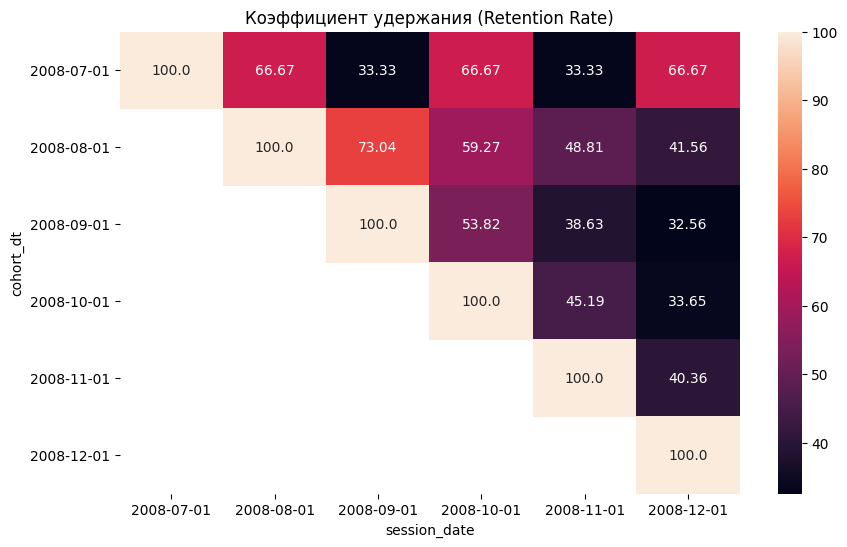

In [15]:
retention = sample_df.pivot('cohort_dt', 'session_date', 'retention_rate')
retention.index = [str(x)[0:10] for x in retention.index]
retention.columns = [str(x)[0:10] for x in retention.columns]

plt.figure(figsize=(10, 6))
sns.heatmap(retention, annot=True, fmt='')
plt.title('Коэффициент удержания (Retention Rate)')
plt.xlabel('session_date')
plt.ylabel('cohort_dt')
plt.show()

**Ответ:**

- Аномалии в когорте 2008.07.01 коэффициент удержания должен постепенно убывать. Возможно из-за тестового периода или технических ошибок, в этот период было только 3 пользователя, все три зарегестрировались и написали посты только в первый месяц, а дальше писали то 2 то 1 пользователь

## Задание 9


На сколько процентов менялось количество постов ежемесячно с 1 сентября по 31 декабря 2008 года? Отобразите таблицу со следующими полями:

- номер месяца;
- количество постов за месяц;
- процент, который показывает, насколько изменилось количество постов в текущем месяце по сравнению с предыдущим.

Если постов стало меньше, значение процента должно быть отрицательным, если больше — положительным. Округлите значение процента до двух знаков после запятой.

Напомним, что при делении одного целого числа на другое в PostgreSQL в результате получится целое число, округлённое до ближайшего целого вниз. Чтобы этого избежать, переведите делимое в тип `numeric`.

| creation_month | posts_count | percentage |
| -------------- | ----------- | ---------- |
| 9 | 70731 | Nan |
| 10 | 63102 | -10.33 |
| ... | ... | ... |

In [16]:
query = '''
SELECT
    *,
    ROUND((count::numeric/LAG(count) OVER() - 1) * 100, 2)
FROM (
    SELECT
        EXTRACT(MONTH FROM creation_date)::int AS creation_month,
        COUNT(id)
    FROM stackoverflow.posts
    WHERE DATE_TRUNC('MONTH', creation_date) BETWEEN '2008-09-01' AND '2008-12-01'
    GROUP BY creation_month
) AS fin
'''

sample_df = pd.read_sql_query(query, con=engine)
sample_df

,creation_month,count,round
0,9,70371,NaN
1,10,63102,-10.33
2,11,46975,-25.56
3,12,44592,-5.07


Постройте круговую диаграмму с количеством постов по месяцам.

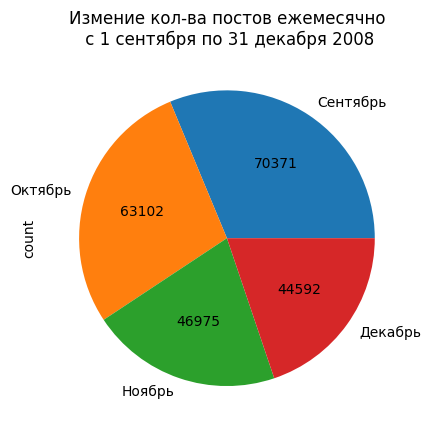

In [17]:
sample_df.plot(labels=['Сентябрь', 'Октябрь', 'Ноябрь', 'Декабрь'], y='count', kind='pie', legend=False,
               autopct=lambda p: int((sample_df['count'].sum()*p/100).round()))
plt.title('Измение кол-ва постов ежемесячно\n с 1 сентября по 31 декабря 2008')
plt.show();

## Задание 10

Выгрузите данные активности пользователя, который опубликовал больше всего постов за всё время. Выведите данные за октябрь 2008 года в таком виде:

- номер недели;
- дата и время последнего поста, опубликованного на этой неделе.

| week_creation | creation_date |
| ------------- | ------------- |
| 40 | 2008-10-05 09:00:58 |
| 41 | 2008-10-12 21:22:23 |
| ... | ... |

In [18]:
query = '''
SELECT
    EXTRACT(WEEK FROM creation_date)::int AS week_creation,
    MAX(creation_date) AS creation_date
FROM stackoverflow.posts
WHERE
    DATE_TRUNC('MONTH', creation_date) = '2008-10-01' AND
    user_id IN (
        SELECT user_id
        FROM stackoverflow.posts
        GROUP BY user_id
        ORDER BY COUNT(id) DESC
        LIMIT 1
    )
GROUP BY week_creation
'''

sample_df = pd.read_sql_query(query, con=engine)
sample_df

,week_creation,creation_date
0,40,2008-10-05 09:00:58
1,41,2008-10-12 21:22:23
2,42,2008-10-19 06:49:30
3,43,2008-10-26 21:44:36
4,44,2008-10-31 22:16:01
